In [1]:
import sys
sys.path.append('../')

import tquant as tq
from datastore import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def modifica_stringhe(lista_stringhe):
    # Lista per memorizzare le stringhe modificate
    stringhe_modificate = []
    
    # Rimozione del prefisso FRA
    prefisso = "fra-"
    for stringa in lista_stringhe:
        if stringa.startswith(prefisso):
            stringa = stringa[len(prefisso):]
        stringhe_modificate.append(stringa)

    # Dizionario delle sostituzioni
    sostituzioni = {
        "1BD": "O/N",
        "2BD": "T/N",
        "3BD": "S/N",
        "CASH": "depo",
        "SWAP": "ois",
        "FRA": "fra",
    }

    # Lista temporanea per memorizzare le stringhe modificate ulteriormente
    stringhe_modificate_finali = []

    # Iterare su ciascuna stringa nella lista delle stringhe modificate
    for stringa in stringhe_modificate:
        for chiave, valore in sostituzioni.items():
            stringa = stringa.replace(chiave, valore)
        stringhe_modificate_finali.append(stringa)
    
    return stringhe_modificate_finali

In [3]:
tq.Settings.evaluation_date = date(2024, 4, 30)

trade_date = tq.Settings.evaluation_date
market_data = {}

# Curves

In [4]:
# import tensorflow as tf 
# from tensorflow.python.framework import dtypes
from datetime import timedelta
import QuantLib as ql
# from typing import Union


In [5]:
ref_date = date(2024, 4, 30)
rates = ir_eur_curve_estr['quote'].values.tolist()
times = ir_eur_curve_estr['daycount'].values/365
times_days = [int(np.round(x,0)) for x in times*365]
dates_tq = [ref_date + timedelta(t) for t in times_days]

evaluation_date_ql = ql.Date.from_date(ref_date)
dates_ql = [evaluation_date_ql + d for d in times_days]
curve_ql = ql.ZeroCurve(dates_ql, rates, ql.ActualActual(ql.ActualActual.ISDA), ql.TARGET())
curve_ql.enableExtrapolation()

curve_tq = tq.RateCurve(reference_date=ref_date,
                         pillars=dates_tq,
                         rates=rates,
                         interp='LINEAR')

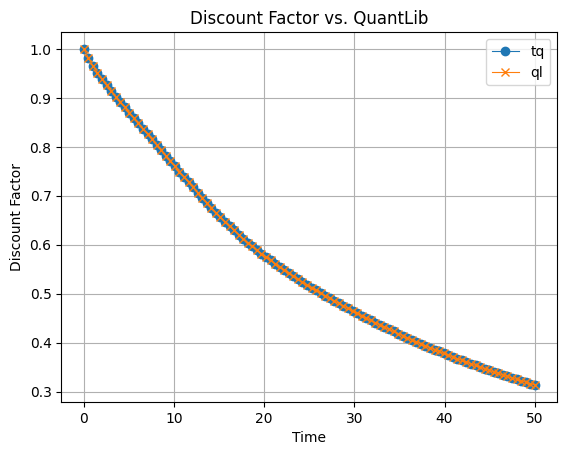

In [6]:
taus = np.linspace(0.0001,50, 100).tolist()
discount_tq = [curve_tq.discount(t) for t in taus]
discount_ql = [curve_ql.discount(t) for t in taus]

plt.plot(taus, discount_tq, label='tq', marker='o',  linewidth=0.8)
plt.plot(taus, discount_ql, label='ql', marker='x',  linewidth=0.8)
plt.xlabel('Time')
plt.ylabel('Discount Factor')
plt.title('Discount Factor vs. QuantLib')
plt.legend()
plt.grid()
plt.show()

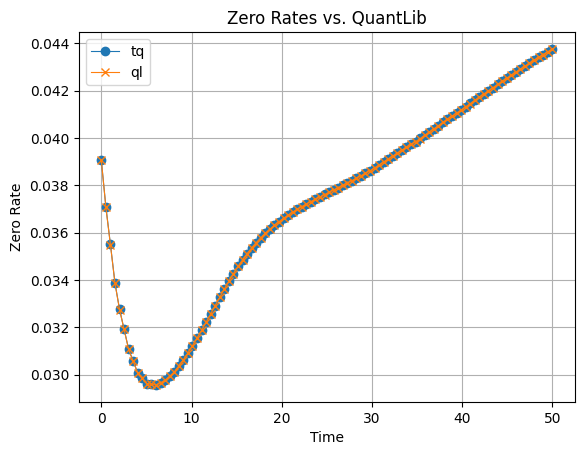

In [7]:
zerorate_tq = [curve_tq.zero_rate(t) for t in taus]
zerorate_ql = [curve_ql.zeroRate(t, ql.Simple).rate() for t in taus]

plt.plot(taus, zerorate_tq, label='tq', marker='o',  linewidth=0.8)
plt.plot(taus, zerorate_ql, label='ql', marker='x',  linewidth=0.8)
plt.xlabel('Time')
plt.ylabel('Zero Rate')
plt.title('Zero Rates vs. QuantLib')
plt.legend()
plt.grid()
plt.show()

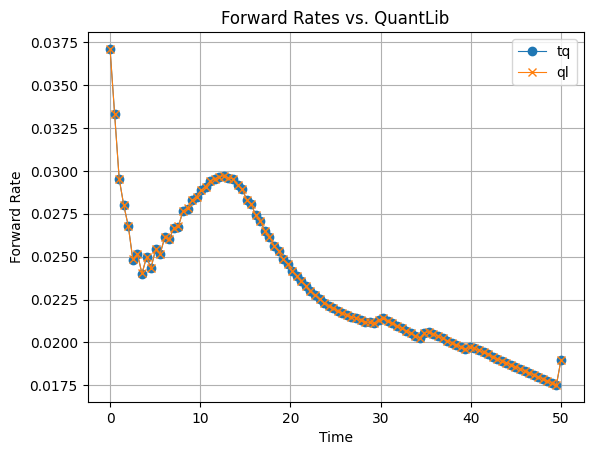

In [8]:
fwdrate_tq = [curve_tq.forward_rate(t, t+0.5) for t in taus]
fwdrate_ql = [curve_ql.forwardRate(t, t+0.5, ql.Simple).rate() for t in taus]

plt.plot(taus, fwdrate_tq, label='tq', marker='o',  linewidth=0.8)
plt.plot(taus, fwdrate_ql, label='ql', marker='x',  linewidth=0.8)
plt.xlabel('Time')
plt.ylabel('Forward Rate')
plt.title('Forward Rates vs. QuantLib')
plt.legend()
plt.grid()
plt.show()

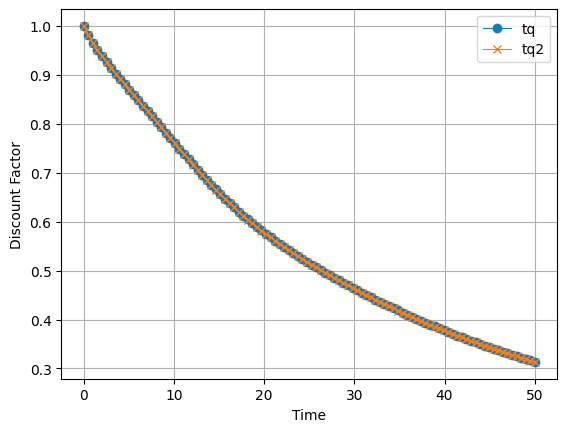

In [9]:
disc_fact = [df.numpy() for df in discount_tq]
curve_from_zcb = tq.RateCurve.from_zcb(ref_date, taus, disc_fact, interp='LINEAR') #[int(n) for n in (np.array(taus)*365).round(0)]

discount_tq = [curve_tq.discount(t) for t in taus]
discount_tq2 = [curve_from_zcb.discount(t) for t in taus]

plt.plot(taus, discount_tq, label='tq', marker='o',  linewidth=0.8)
plt.plot(taus, discount_tq2, label='tq2', marker='x',  linewidth=0.8)
plt.xlabel('Time')
plt.ylabel('Discount Factor')
plt.legend()
plt.grid()
plt.show()

# ESTR Bootstrapping

In [10]:
curve_stripper_eur = tq.CurveBootstrap(evaluation_date=trade_date,
                                   daycount_convention=tq.DayCounterConvention.Actual365,
                                   curve_map=curve_map)

total iteration:  4


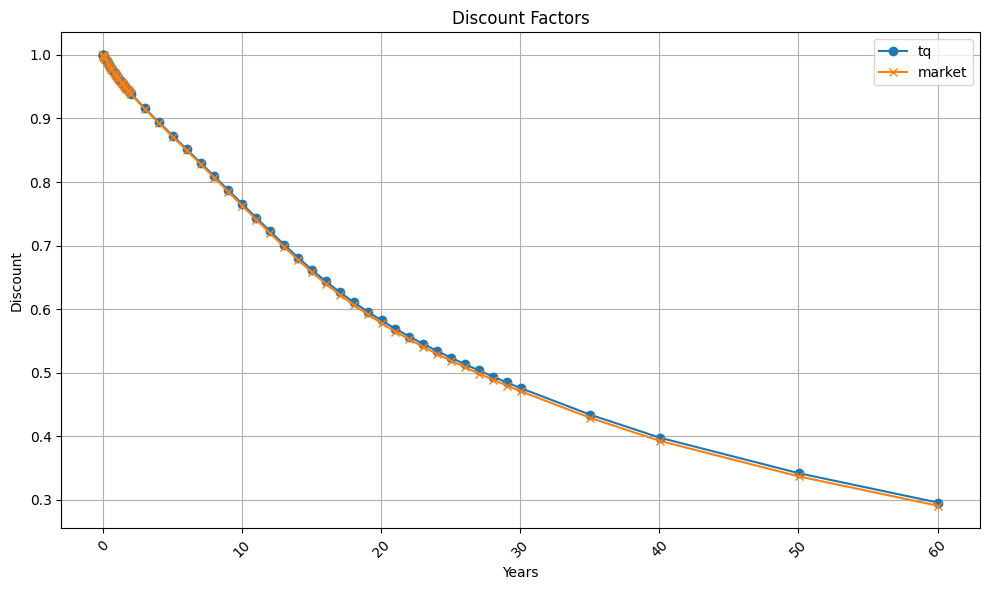

In [11]:
eur_disc_name = "EUR:ESTR"
generators = ir_eur_curve_estr['type'].tolist()#modifica_stringhe(ir_eur_curve_estr['type'])
maturities = list(modifica_stringhe(ir_eur_curve_estr['tenor']))
quotes = ir_eur_curve_estr['quote'].values

estr_curve = curve_stripper_eur.strip(generators, maturities, quotes, eur_disc_name,
                                               currency=tq.Currency.EUR, market_data=market_data)
discount_estr = []
fwd_estr = []
discounts_estr_mkt = ir_eur_disc_estr
for maturity in discounts_estr_mkt['daycount'].values/365:
    discount_estr.append(market_data[eur_disc_name].discount(maturity))
    fwd_estr.append(market_data[eur_disc_name].inst_fwd(maturity))
    

plt.figure(figsize=(10, 6))
plt.plot(discounts_estr_mkt['daycount'].values/365, discount_estr, label= 'tq', marker='o', linestyle='-')
plt.plot(discounts_estr_mkt['daycount'].values/365, discounts_estr_mkt['market_quote'].values, label= 'market', marker='x', linestyle='-')
plt.xlabel('Years')
plt.ylabel('Discount')
plt.title('Discount Factors')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
pd.DataFrame(estr_curve.jacobian)

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,0.005479,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.005478,0.008217,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,-0.008217,0.016433,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.000068,-0.008262,0.000190,0.027579,7.056843e-20,0.000000e+00,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.000068,-0.008262,0.000000,0.000313,4.689224e-02,3.472835e-20,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,-0.000068,-0.008251,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.359445,0.345614,0.338379,0.350336,0.700797,14.446132,0.007892,0.000000,0.000000,0.000000
58,-0.000068,-0.008251,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.350244,0.336184,0.328784,0.340558,0.383018,1.163610,16.368011,0.010335,0.000000,0.000000
59,-0.000068,-0.008251,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.342204,0.327945,0.320400,0.332014,0.374353,1.063088,1.947384,17.116928,0.006432,0.000000
60,-0.000068,-0.008251,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.327053,0.312417,0.304601,0.315912,0.358024,1.012450,1.769865,2.862475,19.342636,0.010526


# Eur6m

In [13]:
# eur_6m_name = "EUR:6M"
# generators_6m = ir_eur_curve_6m['type'].tolist()#modifica_stringhe(ir_eur_curve_6m['type'])
# maturities_6m = list(modifica_stringhe(ir_eur_curve_6m['tenor']))
# quotes_6m = ir_eur_curve_6m['quote'].values

In [14]:
# eur6m_curve = curve_stripper_eur.strip(generators_6m, maturities_6m, quotes_6m, eur_6m_name,
#                                                currency=tq.Currency.EUR, market_data=market_data)